In this notebook, I would like to show you the difference between distance and density based cluster methods.
Kmeans is a well-known algorithm to cluster data. Unfortunately it is often misused.
Real world data is mostly not isotropically distributed, meaning the real-world clusters are not circular and uniformly distributed in all directions. 
Real-world data is often anisotropically distributed, meaning the real-world clusters are spherical and non-uniformly distributed. See the figure below.

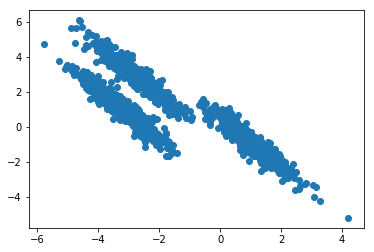

In [39]:
plt.scatter(X_varied[:, 0], X_varied[:, 1])
plt.show()

Clustering these points using Kmeans, results in a suboptimal clustering. See image below.

[0 0 2 ..., 1 2 1]


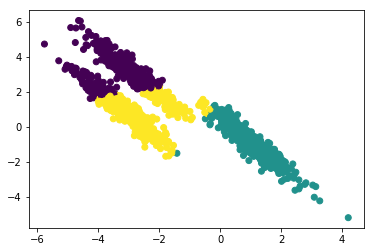

In [40]:
from sklearn.cluster import KMeans
kmeans_y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)
print(kmeans_y_pred)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=kmeans_y_pred)
plt.show()

A more suitable clustering method for the data is needed as well as a method which gives more insight into the structure of the data. For this we can use:  Ordering Points To Identify the Clustering Structure (OPTICS).

OPTICS is a method which does not cluster using the Euclidean distance (or any other distance measure), but rather it uses the density as means to cluster. 

The output of the method is a reachability plot showing peaks and valleys. 

The OPTICS algorithm starts with some point with a high density and searches for points which are reachable. The algorithm thus employs a bottom up strategy.

The peaks indicate cluster borders and the valleys between peaks indicate clusters.

The reachability plot gives insight into the structure of the clusters. Questions such as: Is there hierarchy? What is the variance? How many clusters are there? are easily answered.

The implementation is shown below:


In [41]:
import numpy as np

import plotly.plotly as py
from plotly.graph_objs import Bar, Scatter, Figure, Layout

from sklearn.datasets import make_blobs
from scipy.spatial.distance import pdist
import scipy.spatial.distance as H
import pylab as P

import time
import logging

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

logging.basicConfig(level=logging.INFO, format='%(asctime)s:%(levelname)s:%(filename)s:%(funcName)s:%(lineno)d:%(message)s')

n_samples = 1500
random_state = 170

# Tunable parameters
eps = 1
minpts = 1

# Anisotropicly distributed data
X, y = make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
X_varied = X_aniso
y_varied = y

data = np.array(list(zip(list(X_varied[:,0]), list(X_varied[:,1]))))

def optics_alg(x, k, distMethod='euclidean'): #was euclidean
    tic = time.clock()
    
    if len(x.shape) > 1:
        m, n = x.shape
    else:
        m = x.shape[0]
        n == 1

    try:
        D = H.squareform(pdist(x, distMethod))
        distOK = True
    except:
        print("squareform or pdist error")
        distOK = False

    CD = np.zeros(m)
    RD = np.ones(m) * 1E10

    for i in range(m):
        tempInd = D[i].argsort()
        tempD = D[i][tempInd]
        CD[i] = tempD[k]

    order = []
    seeds = np.arange(m, dtype=np.int)

    ind = 0
    while len(seeds) != 1:
        ob = seeds[ind]
        seedInd = np.where(seeds != ob)
        seeds = seeds[seedInd]

        order.append(ob)
        tempX = np.ones(len(seeds)) * CD[ob]
        tempD = D[ob][seeds]  # [seeds]

        temp = np.column_stack((tempX, tempD))
        mm = np.max(temp, axis=1)
        ii = np.where(RD[seeds] > mm)[0]
        RD[seeds[ii]] = mm[ii]
        ind = np.argmin(RD[seeds])
    toc = time.clock()
    res = toc - tic
    print("Compute time is: %s" % str(res))
    order.append(seeds[0])
    RD[0] = 0  # we set this point to 0 as it does not get overwritten
    return RD, CD, order






To visualize the results, we use Plotly since it gives better zooming capabilities to inspect cluster borders (peaks) in real-world data.

In [42]:
def plot_optics(ordered_reachabilities):

    trace = Bar(x=list(range(0, len(ordered_reachabilities))), y=ordered_reachabilities)
    data = [trace]
    layout = Layout(title='Optics algoritme')
    fig = Figure(data=data, layout=layout)
    iplot(fig)


RD, CD, order = optics_alg(data, 10)
ordered_reachabilities = RD[order]
plot_optics(ordered_reachabilities)

Compute time is: 0.26345299999999927


From the image above, we clearly see 3 clusters. We can also clearly identify cluster borders, which we will find next.

In [43]:
max1 = np.argmax(ordered_reachabilities[400:600])
max2 = np.argmax(ordered_reachabilities[800:1000])
max1, max2

(91, 190)

We reformat the data such that clusters are colored correctly.

The resulting points indicate the peaks.

The first cluster border.

91+400=491

The second cluster border.

190+800=990

clusters are from 0:491 and 491:800 and 990:end.

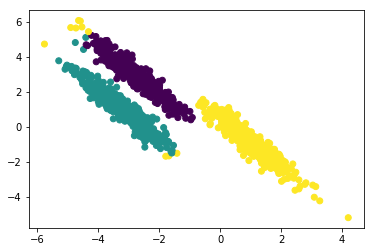

In [44]:
import matplotlib.pyplot as plt
y_pred = np.zeros(len(RD))
np.put(y_pred, order[0:491], 0)
np.put(y_pred, order[491:990], 1)
np.put(y_pred, order[990:len(RD)],2 )


plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.show()

The accuracy for OPTICS is:

In [52]:
target = y_varied
# The target and predicted output have different labels, so we correct them
print(target[0:10])
new_y_pred = []
for i in y_pred:
    if i == 0:
        new_y_pred.append(1)
    if i == 1:
        new_y_pred.append(0)
    if i == 2:
        new_y_pred.append(2)
        
print(new_y_pred[:10])
optics_accuracy = np.sum(np.equal(new_y_pred, target))/len(target)
optics_accuracy


[1 1 0 1 1 2 0 0 0 2]
[1, 1, 0, 1, 1, 2, 0, 0, 0, 2]


0.99133333333333329

The accuracy for Kmeans is:

In [58]:
# Not completely sure if the correct labels are compared between the target and predicted output.
# However, I think it is clear enough for demonstration purposes, the accuracy seems ok.
new_kmeans_y_pred = []
for i in kmeans_y_pred:
    if i == 0:
        new_kmeans_y_pred.append(1)
    if i == 2:
        new_kmeans_y_pred.append(2)
    if i == 1:
        new_kmeans_y_pred.append(0)
kmeans_accuracy = np.sum(np.equal(new_kmeans_y_pred, target))/len(target)
print(new_kmeans_y_pred[:10])
kmeans_accuracy

[1, 1, 2, 1, 1, 0, 1, 1, 2, 0]


0.26333333333333331

Concluding, we learned that not for all data, Kmeans is a good clustering method.
More information can be found in the article: https://www.researchgate.net/profile/Mihael_Ankerst/publication/221214752_OPTICS_Ordering_Points_to_Identify_the_Clustering_Structure/links/00b7d51de53545970f000000/OPTICS-Ordering-Points-to-Identify-the-Clustering-Structure.pdf
